In [1]:
# @title Utils

import math
import torch
import torch.optim as optim

from tqdm import tqdm 

try:
    import gpytorch
except:
    !pip install gpytorch
    import gpytorch

try:
    import botorch
except:
    !pip install botorch
    import botorch

from matplotlib import pyplot as plt
%load_ext autoreload
%autoreload 2

from math import exp
import numpy as np
np.random.seed(1)

# from botorch.models import SingleTaskGP
from gpytorch.constraints import GreaterThan
from gpytorch.mlls import ExactMarginalLogLikelihood
from torch.optim import SGD

# https://gist.github.com/neubig/e859ef0cc1a63d1c2ea4
def rbf_kernel(x1, x2, variance = 0.05):
    return exp(-1 * ((x1-x2) ** 2) / (2*variance))

def gram_matrix(xs):
    return [[rbf_kernel(x1,x2) for x2 in xs] for x1 in xs]

def ground_truth(draw=False):
    xs = np.arange(0, 1, 0.001)
    mean = np.zeros(xs.shape[0])
    gram = gram_matrix(xs)

    np.random.seed(62)
    ys = np.random.multivariate_normal(mean, gram)
    if draw: 
        plt.plot(xs, ys, color='blue', alpha=0.1)

    return xs, ys

def query(x):
    xs, ys = ground_truth()
    xs_new = np.concatenate([xs, x])
    mean_new = np.zeros(xs_new.shape[0])
    gram_new = gram_matrix(xs_new)

    np.random.seed(62)
    ys_new = np.random.multivariate_normal(mean_new, gram_new)

    return ys_new[-x.shape[0]:]

# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 361 kB 6.8 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 387 kB 6.6 MB/s 
     |████████████████████████████████| 722 kB 10.5 MB/s 


In [2]:
#@title SingleTaskGP

#!/usr/bin/env python3
# Copyright (c) Meta Platforms, Inc. and affiliates.
#
# This source code is licensed under the MIT license found in the
# LICENSE file in the root directory of this source tree.

r"""
Gaussian Process Regression models based on GPyTorch models.

These models are often a good starting point and are further documented in the
tutorials.

`SingleTaskGP`, `FixedNoiseGP`, and `HeteroskedasticSingleTaskGP` are all
single-task exact GP models, differing in how they treat noise. They use
relatively strong priors on the Kernel hyperparameters, which work best when
covariates are normalized to the unit cube and outcomes are standardized (zero
mean, unit variance).

These models all work in batch mode (each batch having its own hyperparameters).
When the training observations include multiple outputs, these models use
batching to model outputs independently.

These models all support multiple outputs. However, as single-task models,
`SingleTaskGP`, `FixedNoiseGP`, and `HeteroskedasticSingleTaskGP` should be
used only when the outputs are independent and all use the same training data.
If outputs are independent and outputs have different training data, use the
`ModelListGP`. When modeling correlations between outputs, use a multi-task
model like `MultiTaskGP`.
"""

from __future__ import annotations

from typing import Any, List, Optional, Union

import torch
from botorch import settings
from botorch.models.gpytorch import BatchedMultiOutputGPyTorchModel
from botorch.models.transforms.input import InputTransform
from botorch.models.transforms.outcome import Log, OutcomeTransform
from botorch.models.utils import fantasize as fantasize_flag, validate_input_scaling
from botorch.sampling.samplers import MCSampler
from gpytorch.constraints.constraints import GreaterThan
from gpytorch.distributions.multivariate_normal import MultivariateNormal
from gpytorch.kernels.matern_kernel import MaternKernel
from gpytorch.kernels.scale_kernel import ScaleKernel
from gpytorch.kernels import RBFKernel
from gpytorch.likelihoods.gaussian_likelihood import (
    _GaussianLikelihoodBase,
    FixedNoiseGaussianLikelihood,
    GaussianLikelihood,
)
from gpytorch.likelihoods.likelihood import Likelihood
from gpytorch.likelihoods.noise_models import HeteroskedasticNoise
from gpytorch.means.constant_mean import ConstantMean
from gpytorch.means.mean import Mean
from gpytorch.mlls.noise_model_added_loss_term import NoiseModelAddedLossTerm
from gpytorch.models.exact_gp import ExactGP
from gpytorch.module import Module
from gpytorch.priors.smoothed_box_prior import SmoothedBoxPrior
from gpytorch.priors.torch_priors import GammaPrior
from torch import Tensor


MIN_INFERRED_NOISE_LEVEL = 1e-4


class SingleTaskGP(BatchedMultiOutputGPyTorchModel, ExactGP):
    r"""A single-task exact GP model.

    A single-task exact GP using relatively strong priors on the Kernel
    hyperparameters, which work best when covariates are normalized to the unit
    cube and outcomes are standardized (zero mean, unit variance).

    This model works in batch mode (each batch having its own hyperparameters).
    When the training observations include multiple outputs, this model will use
    batching to model outputs independently.

    Use this model when you have independent output(s) and all outputs use the
    same training data. If outputs are independent and outputs have different
    training data, use the ModelListGP. When modeling correlations between
    outputs, use the MultiTaskGP.

    Example:
        >>> train_X = torch.rand(20, 2)
        >>> train_Y = torch.sin(train_X).sum(dim=1, keepdim=True)
        >>> model = SingleTaskGP(train_X, train_Y)
    """

    def __init__(
        self,
        train_X: Tensor,
        train_Y: Tensor,
        likelihood: Optional[Likelihood] = None,
        covar_module: Optional[Module] = None,
        mean_module: Optional[Mean] = None,
        outcome_transform: Optional[OutcomeTransform] = None,
        input_transform: Optional[InputTransform] = None,
    ) -> None:
        r"""
        Args:
            train_X: A `batch_shape x n x d` tensor of training features.
            train_Y: A `batch_shape x n x m` tensor of training observations.
            likelihood: A likelihood. If omitted, use a standard
                GaussianLikelihood with inferred noise level.
            covar_module: The module computing the covariance (Kernel) matrix.
                If omitted, use a `MaternKernel`.
            mean_module: The mean function to be used. If omitted, use a
                `ConstantMean`.
            outcome_transform: An outcome transform that is applied to the
                training data during instantiation and to the posterior during
                inference (that is, the `Posterior` obtained by calling
                `.posterior` on the model will be on the original scale).
            input_transform: An input transform that is applied in the model's
                forward pass.
        """
        with torch.no_grad():
            transformed_X = self.transform_inputs(
                X=train_X, input_transform=input_transform
            )
        if outcome_transform is not None:
            train_Y, _ = outcome_transform(train_Y)
        self._validate_tensor_args(X=transformed_X, Y=train_Y)
        ignore_X_dims = getattr(self, "_ignore_X_dims_scaling_check", None)
        validate_input_scaling(
            train_X=transformed_X, train_Y=train_Y, ignore_X_dims=ignore_X_dims
        )
        self._set_dimensions(train_X=train_X, train_Y=train_Y)
        train_X, train_Y, _ = self._transform_tensor_args(X=train_X, Y=train_Y)
        if likelihood is None:
            # noise_prior = GammaPrior(1.1, 0.05)
            noise_prior = GammaPrior(concentration=0.5, rate=1)
            noise_prior_mode = (noise_prior.concentration - 1) / noise_prior.rate
            likelihood = GaussianLikelihood(
                noise_prior=noise_prior,
                batch_shape=self._aug_batch_shape,
                noise_constraint=GreaterThan(
                    MIN_INFERRED_NOISE_LEVEL,
                    transform=None,
                    initial_value=noise_prior_mode,
                ),
            )
        else:
            self._is_custom_likelihood = True
        ExactGP.__init__(self, train_X, train_Y, likelihood)
        if mean_module is None:
            mean_module = ConstantMean(batch_shape=self._aug_batch_shape)
        self.mean_module = mean_module
        if covar_module is None:
            covar_module = \
                ScaleKernel(
                    # MaternKernel(
                    #     nu=2.5,
                    #     ard_num_dims=transformed_X.shape[-1],
                    #     batch_shape=self._aug_batch_shape,
                    #     lengthscale_prior=GammaPrior(3.0, 6.0),),
                    RBFKernel(
                        ard_num_dims=transformed_X.shape[-1],
                        batch_shape=self._aug_batch_shape,
                        lengthscale_prior=GammaPrior(3.0, 6.0),),
                    batch_shape=self._aug_batch_shape,
                    outputscale_prior=GammaPrior(2.0, 0.15),
                )
            self._subset_batch_dict = {
                "likelihood.noise_covar.raw_noise": -2,
                "mean_module.raw_constant": -1,
                "covar_module.raw_outputscale": -1,
                "covar_module.base_kernel.raw_lengthscale": -3,
            }
        self.covar_module = covar_module
        # TODO: Allow subsetting of other covar modules
        if outcome_transform is not None:
            self.outcome_transform = outcome_transform
        if input_transform is not None:
            self.input_transform = input_transform
        self.to(train_X)

    def forward(self, x: Tensor) -> MultivariateNormal:
        if self.training:
            x = self.transform_inputs(x)
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return MultivariateNormal(mean_x, covar_x)

In [3]:
#@title ModelInit

train = False
noise = False

train_x = np.linspace(0, 1, 4)
train_x = np.append(train_x, np.array([0.2]))
train_y = query(train_x)

train_x = torch.tensor(train_x, dtype=torch.float64)
train_y = torch.tensor(train_y, dtype=torch.float64)
train_x = train_x[:, None]
train_y = train_y[:, None]

model = SingleTaskGP(train_X=train_x, train_Y=train_y)
if noise:
    model.likelihood.noise_covar.register_constraint(
        "raw_noise", GreaterThan(1e-6))

mll = ExactMarginalLogLikelihood(likelihood=model.likelihood, model=model)
mll = mll.to(train_x)

if not train:
    model.covar_module.base_kernel.lengthscale = 1
    model.covar_module.outputscale = 1
    model.likelihood.noise = 1e-10
else:

    optimizer = SGD([{'params': model.parameters()}], lr=0.05)
    NUM_EPOCHS = 10000

    model.train()

    for epoch in range(NUM_EPOCHS):
        optimizer.zero_grad()
        # forward pass through the model to 
        # obtain the output MultivariateNormal
        output = model(train_x)
        # Compute negative marginal log likelihood
        loss = - mll(output, model.train_targets)
        # back prop gradients
        loss.backward()
        # print every 200 iterations
        if (epoch + 1) % 200 == 0:
            print(
                f"Epoch {epoch+1:>3}/{NUM_EPOCHS} - Loss: {loss.item():>4.10f} "
                f"lengthscale: {model.covar_module.base_kernel.lengthscale.item():>4.10f} " 
                f"outputscale: {model.covar_module.outputscale.item():>4.10f} " 
                f"noise: {model.likelihood.noise.item():>4.10f}" 
             )
                    
        optimizer.step()

# set model (and likelihood)
model.eval()

SingleTaskGP(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (noise_prior): GammaPrior()
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (mean_module): ConstantMean()
  (covar_module): ScaleKernel(
    (base_kernel): RBFKernel(
      (lengthscale_prior): GammaPrior()
      (raw_lengthscale_constraint): Positive()
    )
    (outputscale_prior): GammaPrior()
    (raw_outputscale_constraint): Positive()
  )
)

/usr/local/lib/python3.7/dist-packages/gpytorch/distributions/multivariate_normal.py:263: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-10.
  NumericalWarning,


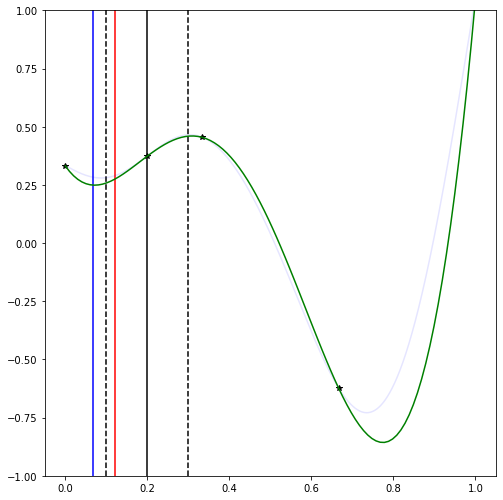

In [ ]:
#@title Naive Myopic
prev_x = 0.2
temp = []
for x0 in torch.linspace(prev_x-0.1, prev_x+0.1, 10):
    x0 = x0.reshape(1)
    p_y0_on_x0_D0 = model.posterior(x0)

    p_f_on_D1 = model.condition_on_observations(
        x0, p_y0_on_x0_D0.mean
    )
    
    for a in torch.linspace(x0.item()-0.1, x0.item()+0.1, 10):
        a = a.reshape(1)
        p_y1_a_D1 = p_f_on_D1.posterior(a)
        temp.append([x0, a, p_y1_a_D1.mean])

temp = torch.tensor(temp)
best = torch.argmin(temp, dim=0)[2].item()
best_x, best_a, best_hes = temp[best].numpy().tolist()

plt.figure(figsize=(7, 7))
ground_truth(draw=True)

plt.vlines(prev_x, -1, 1, color='black')
plt.vlines(prev_x-0.1, -1, 1, color='black', linestyle='--')
plt.vlines(prev_x+0.1, -1, 1, color='black', linestyle='--')

plt.vlines(best_x, -1, 1, color='red')
plt.vlines(best_a, -1, 1, color='blue')

plt.plot(
    train_x.cpu().numpy(), 
    train_y.cpu().numpy(), 
    'k*')

# compute posterior
test_x = torch.linspace(0, 1, 100)
posterior = model.posterior(test_x)
test_y = posterior.mean
lower, upper = posterior.mvn.confidence_region()

plt.plot(
    test_x.cpu().detach().numpy(), 
    test_y.cpu().detach().numpy(), 
    'green')

plt.fill_between(
    test_x.cpu().detach().numpy(), 
    lower.cpu().detach().numpy(), 
    upper.cpu().detach().numpy(), 
    alpha=0.25)

plt.tight_layout()
plt.ylim(-1, 1)

plt.show()

100%|██████████| 10/10 [00:38<00:00,  3.84s/it]
/usr/local/lib/python3.7/dist-packages/gpytorch/distributions/multivariate_normal.py:263: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-10.
  NumericalWarning,


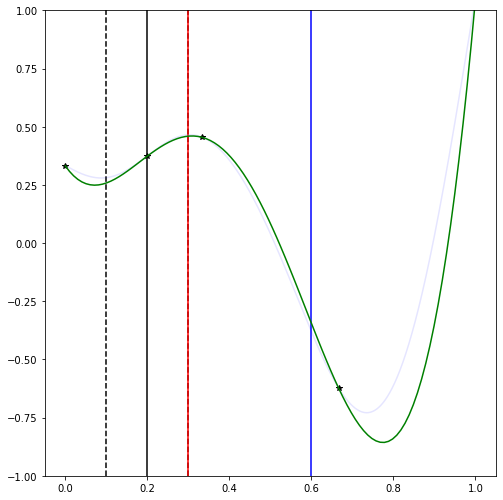

In [ ]:
#@title Naive 3 steps

prev_x = 0.2
temp = []
for x0 in tqdm(torch.linspace(prev_x-0.1, prev_x+0.1, 10)):
    x0 = x0.reshape(1)
    p_y0_on_x0_D0 = model.posterior(x0)
    p_f_on_D1 = model.condition_on_observations(
        x0, p_y0_on_x0_D0.mean
    )

    for x1 in torch.linspace(x0.item()-0.1, x0.item()+0.1, 10):
        x1 = x1.reshape(1)
        p_y1_on_x1_D1 = p_f_on_D1.posterior(x1)
        p_f_on_D2 = p_f_on_D1.condition_on_observations(
            x1, p_y1_on_x1_D1.mean
        )

        for x2 in torch.linspace(x1.item()-0.1, x1.item()+0.1, 10):
            x2 = x2.reshape(1)
            p_y2_on_x2_D2 = p_f_on_D2.posterior(x2)
            p_f_on_D3 = p_f_on_D2.condition_on_observations(
                x2, p_y2_on_x2_D2.mean
            )

            for a in torch.linspace(x2.item()-0.1, x2.item()+0.1, 10):
                a = a.reshape(1)
                p_y3_a_D3 = p_f_on_D3.posterior(a)
                temp.append([x0, a, p_y3_a_D3.mean])

temp = torch.tensor(temp)
best = torch.argmin(temp, dim=0)[2].item()
best_x, best_a, best_hes = temp[best].numpy().tolist()

plt.figure(figsize=(7, 7))
ground_truth(draw=True)

plt.vlines(prev_x, -1, 1, color='black')
plt.vlines(prev_x-0.1, -1, 1, color='black', linestyle='--')
plt.vlines(prev_x+0.1, -1, 1, color='black', linestyle='--')

plt.vlines(best_x, -1, 1, color='red')
plt.vlines(best_a, -1, 1, color='blue')

plt.plot(
    train_x.cpu().numpy(), 
    train_y.cpu().numpy(), 
    'k*')

# compute posterior
test_x = torch.linspace(0, 1, 100)
posterior = model.posterior(test_x)
test_y = posterior.mean
lower, upper = posterior.mvn.confidence_region()

plt.plot(
    test_x.cpu().detach().numpy(), 
    test_y.cpu().detach().numpy(), 
    'green')

plt.fill_between(
    test_x.cpu().detach().numpy(), 
    lower.cpu().detach().numpy(), 
    upper.cpu().detach().numpy(), 
    alpha=0.25)

plt.tight_layout()
plt.ylim(-1, 1)

plt.show()

100%|██████████| 10/10 [04:11<00:00, 25.13s/it]
/usr/local/lib/python3.7/dist-packages/gpytorch/distributions/multivariate_normal.py:263: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-10.
  NumericalWarning,


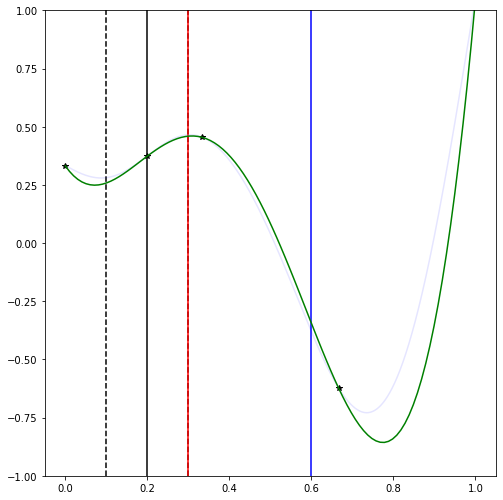

In [ ]:
#@title Joint 3 Steps

def compute_ehig(x0, x1, x2, a):
    p_y0_on_x0_D0 = model.posterior(x0)
    p_f_on_D1 = model.condition_on_observations(
        x0, p_y0_on_x0_D0.mean
    )

    p_y1_on_x1_D1 = p_f_on_D1.posterior(x1)
    p_f_on_D2 = p_f_on_D1.condition_on_observations(
        x1, p_y1_on_x1_D1.mean
    )

    p_y2_on_x2_D2 = p_f_on_D2.posterior(x2)
    p_f_on_D3 = p_f_on_D2.condition_on_observations(
        x2, p_y2_on_x2_D2.mean
    )

    p_y3_a_D3 = p_f_on_D3.posterior(a)

    ehig = p_y3_a_D3.mean

    return ehig

prev_x = 0.2
temp = []
for x0 in tqdm(torch.linspace(prev_x-0.1, prev_x+0.1, 10)):
    if not 0 <= x0.item() <= 1: continue
    x0 = x0.reshape(1)
    for x1 in torch.linspace(x0.item()-0.1, x0.item()+0.1, 10):
        if not 0 <= x1.item() <= 1: continue
        x1 = x1.reshape(1)
        for x2 in torch.linspace(x1.item()-0.1, x1.item()+0.1, 10):
            if not 0 <= x2.item() <= 1: continue
            x2 = x2.reshape(1)
            for a in torch.linspace(x2.item()-0.1, x2.item()+0.1, 10):
                if not 0 <= a.item() <= 1: continue
                a = a.reshape(1)

                ehig = compute_ehig(x0, x1, x2, a)

                temp.append([x0, a, ehig])

temp = torch.tensor(temp)
best = torch.argmin(temp, dim=0)[2].item()
best_x, best_a, best_hes = temp[best].numpy().tolist()

plt.figure(figsize=(7, 7))
ground_truth(draw=True)

plt.vlines(prev_x, -1, 1, color='black')
plt.vlines(prev_x-0.1, -1, 1, color='black', linestyle='--')
plt.vlines(prev_x+0.1, -1, 1, color='black', linestyle='--')

plt.vlines(best_x, -1, 1, color='red')
plt.vlines(best_a, -1, 1, color='blue')

plt.plot(
    train_x.cpu().numpy(), 
    train_y.cpu().numpy(), 
    'k*')

# compute posterior
test_x = torch.linspace(0, 1, 100)
posterior = model.posterior(test_x)
test_y = posterior.mean
lower, upper = posterior.mvn.confidence_region()

plt.plot(
    test_x.cpu().detach().numpy(), 
    test_y.cpu().detach().numpy(), 
    'green')

plt.fill_between(
    test_x.cpu().detach().numpy(), 
    lower.cpu().detach().numpy(), 
    upper.cpu().detach().numpy(), 
    alpha=0.25)

plt.tight_layout()
plt.ylim(-1, 1)

plt.show()

100%|██████████| 2/2 [00:00<00:00,  4.43it/s]
/usr/local/lib/python3.7/dist-packages/gpytorch/distributions/multivariate_normal.py:263: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-10.
  NumericalWarning,


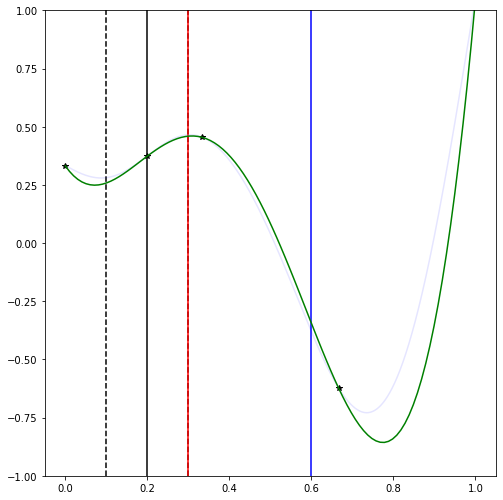

In [ ]:
#@title Joint 3 Steps with sigmoid

def compute_ehig(x0, x1, x2, a):
    '''
    x0 to a: unconstraint optimization parameters
    '''
    x0 = torch.sigmoid(x0) * 0.2 + (prev_x - 0.1)

    x1 = torch.sigmoid(x1) * 0.2 + (x0 - 0.1)

    x2 = torch.sigmoid(x2) * 0.2 + (x1 - 0.1)
    # x2 = x2 * 2

    a = torch.sigmoid(a) * 0.2 + (x2 - 0.1)
    # a = a * 2

    x0 = x0.reshape(1)
    x1 = x1.reshape(1)
    x2 = x2.reshape(1)
    a = a.reshape(1)

    p_y0_on_x0_D0 = model.posterior(x0)
    p_f_on_D1 = model.condition_on_observations(
        x0, p_y0_on_x0_D0.mean
    )

    p_y1_on_x1_D1 = p_f_on_D1.posterior(x1)
    p_f_on_D2 = p_f_on_D1.condition_on_observations(
        x1, p_y1_on_x1_D1.mean
    )

    p_y2_on_x2_D2 = p_f_on_D2.posterior(x2)
    p_f_on_D3 = p_f_on_D2.condition_on_observations(
        x2, p_y2_on_x2_D2.mean
    )

    p_y3_a_D3 = p_f_on_D3.posterior(a)

    ehig = p_y3_a_D3.mean

    return x0, a, ehig

prev_x = 0.2
temp = []
for x0 in tqdm(torch.linspace(-10, 10, 2)):
    for x1 in torch.linspace(-10, 10, 2):
        for x2 in torch.linspace(-10, 10, 2):
            for a in torch.linspace(-10, 10, 2):
                x0_, a_, ehig = compute_ehig(x0, x1, x2, a)

                temp.append([x0_, a_, ehig])

temp = torch.tensor(temp)
best = torch.argmin(temp, dim=0)[2].item()
best_x, best_a, best_hes = temp[best].numpy().tolist()

plt.figure(figsize=(7, 7))
ground_truth(draw=True)

plt.vlines(prev_x, -1, 1, color='black')
plt.vlines(prev_x-0.1, -1, 1, color='black', linestyle='--')
plt.vlines(prev_x+0.1, -1, 1, color='black', linestyle='--')

plt.vlines(best_x, -1, 1, color='red')
plt.vlines(best_a, -1, 1, color='blue')

plt.plot(
    train_x.cpu().numpy(), 
    train_y.cpu().numpy(), 
    'k*')

# compute posterior
test_x = torch.linspace(0, 1, 100)
posterior = model.posterior(test_x)
test_y = posterior.mean
lower, upper = posterior.mvn.confidence_region()

plt.plot(
    test_x.cpu().detach().numpy(), 
    test_y.cpu().detach().numpy(), 
    'green')

plt.fill_between(
    test_x.cpu().detach().numpy(), 
    lower.cpu().detach().numpy(), 
    upper.cpu().detach().numpy(), 
    alpha=0.25)

plt.tight_layout()
plt.ylim(-1, 1)

plt.show()

  0%|          | 2/1000 [00:00<01:14, 13.37it/s]

0.22571353237286884 tensor([2.0772], requires_grad=True) tensor([0.9841], requires_grad=True) tensor([1.0172], requires_grad=True) tensor([5.6867], requires_grad=True)


 10%|█         | 105/1000 [00:06<00:33, 26.52it/s]

-0.3323491581995763 tensor([6.0432], requires_grad=True) tensor([5.1912], requires_grad=True) tensor([5.2136], requires_grad=True) tensor([9.5117], requires_grad=True)


 20%|██        | 204/1000 [00:10<00:31, 25.24it/s]

-0.3394838950911602 tensor([6.9143], requires_grad=True) tensor([6.0788], requires_grad=True) tensor([6.1005], requires_grad=True) tensor([10.3721], requires_grad=True)


 31%|███       | 306/1000 [00:14<00:26, 25.86it/s]

-0.3416298569607429 tensor([7.4703], requires_grad=True) tensor([6.6401], requires_grad=True) tensor([6.6616], requires_grad=True) tensor([10.9243], requires_grad=True)


 40%|████      | 405/1000 [00:18<00:23, 25.72it/s]

-0.3425976920581059 tensor([7.8825], requires_grad=True) tensor([7.0549], requires_grad=True) tensor([7.0763], requires_grad=True) tensor([11.3349], requires_grad=True)


 50%|█████     | 504/1000 [00:21<00:19, 25.65it/s]

-0.34312794554721415 tensor([8.2118], requires_grad=True) tensor([7.3857], requires_grad=True) tensor([7.4070], requires_grad=True) tensor([11.6631], requires_grad=True)


 60%|██████    | 603/1000 [00:25<00:15, 26.04it/s]

-0.343454235499848 tensor([8.4871], requires_grad=True) tensor([7.6619], requires_grad=True) tensor([7.6832], requires_grad=True) tensor([11.9377], requires_grad=True)


 71%|███████   | 706/1000 [00:31<00:11, 25.77it/s]

-0.3436709541074331 tensor([8.7244], requires_grad=True) tensor([7.8999], requires_grad=True) tensor([7.9212], requires_grad=True) tensor([12.1745], requires_grad=True)


 80%|████████  | 805/1000 [00:35<00:07, 25.76it/s]

-0.34382422553123165 tensor([8.9336], requires_grad=True) tensor([8.1096], requires_grad=True) tensor([8.1308], requires_grad=True) tensor([12.3833], requires_grad=True)


 90%|█████████ | 904/1000 [00:39<00:03, 25.77it/s]

-0.34393644482446556 tensor([9.1212], requires_grad=True) tensor([8.2975], requires_grad=True) tensor([8.3187], requires_grad=True) tensor([12.5706], requires_grad=True)


100%|██████████| 1000/1000 [00:42<00:00, 23.40it/s]
/usr/local/lib/python3.7/dist-packages/gpytorch/distributions/multivariate_normal.py:263: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-10.
  NumericalWarning,


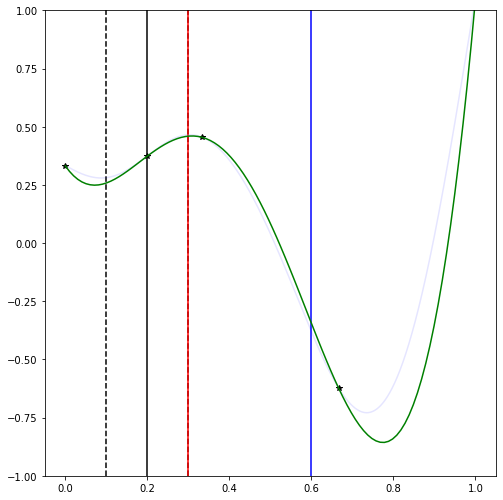

In [ ]:
#@title Joint 3 Steps with sigmoid and adam

def compute_ehig(x0, x1, x2, a):
    '''
    x0 to a: unconstraint optimization parameters
    '''

    x0 = torch.sigmoid(x0) * 0.2 + (prev_x - 0.1)

    x1 = torch.sigmoid(x1) * 0.2 + (x0 - 0.1)

    x2 = torch.sigmoid(x2) * 0.2 + (x1 - 0.1)
    # x2 = x2 * 2

    a = torch.sigmoid(a) * 0.2 + (x2 - 0.1)
    # a = a * 2

    x0 = x0.reshape(1)
    x1 = x1.reshape(1)
    x2 = x2.reshape(1)
    a = a.reshape(1)

    p_y0_on_x0_D0 = model.posterior(x0)
    p_f_on_D1 = model.condition_on_observations(
        x0, p_y0_on_x0_D0.mean
    )

    p_y1_on_x1_D1 = p_f_on_D1.posterior(x1)
    p_f_on_D2 = p_f_on_D1.condition_on_observations(
        x1, p_y1_on_x1_D1.mean
    )

    p_y2_on_x2_D2 = p_f_on_D2.posterior(x2)
    p_f_on_D3 = p_f_on_D2.condition_on_observations(
        x2, p_y2_on_x2_D2.mean
    )

    p_y3_a_D3 = p_f_on_D3.posterior(a)
    ehig = p_y3_a_D3.mean

    return x0, a, ehig.squeeze()

prev_x = 0.2
temp = []

import torch.optim as optim
x0 = (torch.rand(1)*6).requires_grad_(True)
x1 = (torch.rand(1)*6).requires_grad_(True)
x2 = (torch.rand(1)*6).requires_grad_(True)
a = (torch.rand(1)*6).requires_grad_(True)

optimizer = optim.Adam([x0, x1, x2, a], lr=0.1)
for epoch in tqdm(range(1000)):
    optimizer.zero_grad()
    x0_, a_, ehig = compute_ehig(x0, x1, x2, a)
    temp.append([x0_, a_, ehig])
    ehig.backward(retain_graph=True)
    optimizer.step()

    if epoch % 100 == 0: 
        print(ehig.item(), x0, x1, x2, a)


temp = torch.tensor(temp)
best = torch.argmin(temp, dim=0)[2].item()
best_x, best_a, best_hes = temp[best].numpy().tolist()

plt.figure(figsize=(7, 7))
ground_truth(draw=True)

plt.vlines(prev_x, -1, 1, color='black')
plt.vlines(prev_x-0.1, -1, 1, color='black', linestyle='--')
plt.vlines(prev_x+0.1, -1, 1, color='black', linestyle='--')

plt.vlines(best_x, -1, 1, color='red')
plt.vlines(best_a, -1, 1, color='blue')

plt.plot(
    train_x.cpu().numpy(), 
    train_y.cpu().numpy(), 
    'k*')

# compute posterior
test_x = torch.linspace(0, 1, 100)
posterior = model.posterior(test_x)
test_y = posterior.mean
lower, upper = posterior.mvn.confidence_region()

plt.plot(
    test_x.cpu().detach().numpy(), 
    test_y.cpu().detach().numpy(), 
    'green')

plt.fill_between(
    test_x.cpu().detach().numpy(), 
    lower.cpu().detach().numpy(), 
    upper.cpu().detach().numpy(), 
    alpha=0.25)

plt.tight_layout()
plt.ylim(-1, 1)

plt.show()

  1%|          | 1/100 [00:07<12:01,  7.29s/it]

x0  11.35047721862793 a 11.302826881408691 loss -0.14858449395709517


 11%|█         | 11/100 [00:17<01:38,  1.10s/it]

x0  28.268224716186523 a 28.235153198242188 loss -0.3444801443660939


 21%|██        | 21/100 [00:27<01:18,  1.01it/s]

x0  33.35722732543945 a 33.324222564697266 loss -0.3444729820140178


 31%|███       | 31/100 [00:38<01:12,  1.04s/it]

x0  35.321014404296875 a 35.286922454833984 loss -0.34447985936994807


 41%|████      | 41/100 [00:48<00:57,  1.02it/s]

x0  36.093441009521484 a 36.05855941772461 loss -0.34447970397551836


 51%|█████     | 51/100 [00:58<00:48,  1.01it/s]

x0  36.39421844482422 a 36.35890579223633 loss -0.34447786928598767


 61%|██████    | 61/100 [01:08<00:39,  1.00s/it]

x0  36.50968551635742 a 36.47417068481445 loss -0.34447996742307213


 71%|███████   | 71/100 [01:18<00:29,  1.03s/it]

x0  36.553443908691406 a 36.51783752441406 loss -0.3444764829004285


 81%|████████  | 81/100 [01:29<00:19,  1.03s/it]

x0  36.569854736328125 a 36.534202575683594 loss -0.34447831042929966


 91%|█████████ | 91/100 [01:39<00:09,  1.06s/it]

x0  36.57595443725586 a 36.54029083251953 loss -0.34448103721996726


100%|██████████| 100/100 [01:48<00:00,  1.09s/it]
/usr/local/lib/python3.7/dist-packages/gpytorch/distributions/multivariate_normal.py:263: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-10.
  NumericalWarning,


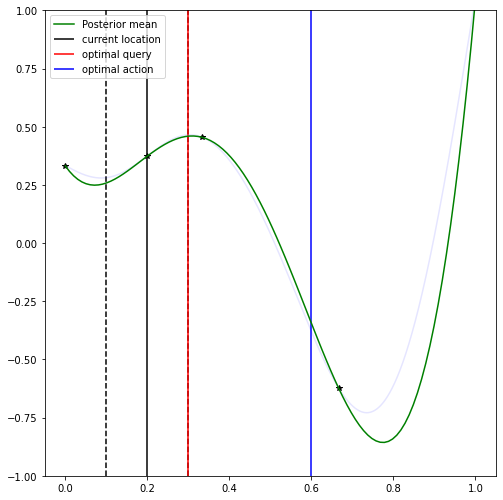

In [ ]:
#@title Joint 3 Steps with sigmoid and adam and sampling

from botorch.sampling.samplers import SobolQMCNormalSampler
from botorch import settings

def compute_ehig(x0, x1, x2, a):
    '''
    x0 to a: unconstraint optimization parameters
    '''
    with settings.propagate_grads(state=True):

        x0 = torch.sigmoid(x0) * 0.2 + (prev_x - 0.1)
        x1 = torch.sigmoid(x1) * 0.2 + (x0 - 0.1)
        x2 = torch.sigmoid(x2) * 0.2 + (x1 - 0.1)
        a = torch.sigmoid(a) * 0.2 + (x2 - 0.1)

        ehigs = 0
        p_y0_on_x0_D0 = model.posterior(x0)
        sampler = SobolQMCNormalSampler(
            num_samples=4, 
            resample=False, collapse_batch_dims=True
        )
        sample_y0_on_x0_D0 = sampler(p_y0_on_x0_D0)

        for ind_x1, y0_on_x0_D0 in enumerate(sample_y0_on_x0_D0):
            p_f_on_D1 = model.condition_on_observations(
                x0, y0_on_x0_D0
            )
            p_y1_on_x1_D1 = p_f_on_D1.posterior(x1[ind_x1, :])
            sample_y1_on_x1_D1 = sampler(p_y1_on_x1_D1)

            for ind_x2, y1_on_x1_D1 in enumerate(sample_y1_on_x1_D1):
                p_f_on_D2 = p_f_on_D1.condition_on_observations(
                    x1[ind_x1, :], y1_on_x1_D1
                )
                p_y2_on_x2_D2 = p_f_on_D2.posterior(x2[ind_x1, ind_x2, :])
                sample_y2_on_x2_D2 = sampler(p_y2_on_x2_D2)

                for ind_a, p_y2_on_x2_D2 in enumerate(sample_y2_on_x2_D2):
                    p_f_on_D3 = p_f_on_D2.condition_on_observations(
                        x2[ind_x1, ind_x2, :], p_y2_on_x2_D2
                    )
                    p_y3_a_D3 = p_f_on_D3.posterior(a[ind_x1, ind_x2, ind_a, :])

                    ehig = p_y3_a_D3.mean
                    ehigs = ehigs + ehig
        
        ehig = ehigs / (4**3)
    return x0, a, ehig.squeeze()

prev_x = 0.2
temp = []

x0 = (torch.rand(1)*10).requires_grad_(True)
x1 = (torch.rand(4, 1)*10).requires_grad_(True)
x2 = (torch.rand(4, 4, 1)*10).requires_grad_(True)
a =  (torch.rand(4, 4, 4, 1)*10).requires_grad_(True)

optimizer = optim.Adam([x0, x1, x2, a], lr=5)
for epoch in tqdm(range(100)):
    optimizer.zero_grad()
    x0_, a_, ehig = compute_ehig(x0, x1, x2, a)
    temp.append([x0_, a_, ehig])
    ehig.backward(retain_graph=True)
    optimizer.step()
    
    if epoch % 10 == 0: 
        print('x0 ', x0.item(), 'a', a[0, 0, 0].item(), 'loss', ehig.item())

# for x0 in tqdm(torch.linspace(-10, 10, 2)):
#     x0 = x0.reshape(1)
#     x0_, a_, ehig = compute_ehig(x0, x1, x2, a)
#     print(ehig)

tmp = []
for i in range(len(temp)):
    tmp.append([temp[i][0], temp[i][1][0, 0, 0], temp[i][2]])
    
tmp = torch.tensor(tmp)
best = torch.argmin(tmp, dim=0)[2].item()
best_x, best_a, best_hes = tmp[best].numpy().tolist()

plt.figure(figsize=(7, 7))
ground_truth(draw=True)

plt.vlines(prev_x, -1, 1, color='black', label='current location')
plt.vlines(prev_x-0.1, -1, 1, color='black', linestyle='--')
plt.vlines(prev_x+0.1, -1, 1, color='black', linestyle='--')

plt.vlines(best_x, -1, 1, color='red', label='optimal query')
plt.vlines(best_a, -1, 1, color='blue', label='optimal action')

plt.plot(
    train_x.cpu().numpy(), 
    train_y.cpu().numpy(), 
    'k*')

# compute posterior
test_x = torch.linspace(0, 1, 100)
posterior = model.posterior(test_x)
test_y = posterior.mean
lower, upper = posterior.mvn.confidence_region()

plt.plot(
    test_x.cpu().detach().numpy(), 
    test_y.cpu().detach().numpy(), 
    'green', label='Posterior mean')

plt.fill_between(
    test_x.cpu().detach().numpy(), 
    lower.cpu().detach().numpy(), 
    upper.cpu().detach().numpy(), 
    alpha=0.25)

plt.tight_layout()
plt.ylim(-1, 1)
plt.legend()

plt.show()

  5%|▌         | 1/20 [00:17<05:34, 17.62s/it]

x0  2.823533535003662 a 4.136483669281006 loss -0.67855099624037


 15%|█▌        | 3/20 [00:48<04:35, 16.18s/it]

x0  5.101978302001953 a 6.4686479568481445 loss -0.8459669380569877


 25%|██▌       | 5/20 [01:20<03:56, 15.74s/it]

x0  6.542238712310791 a 7.975590229034424 loss -0.8403761648798861


 35%|███▌      | 7/20 [01:50<03:20, 15.43s/it]

x0  7.593979358673096 a 9.083908081054688 loss -0.8394244419291946


 45%|████▌     | 9/20 [02:20<02:47, 15.24s/it]

x0  8.405562400817871 a 9.941834449768066 loss -0.8391964522576896


 55%|█████▌    | 11/20 [02:51<02:16, 15.21s/it]

x0  9.049580574035645 a 10.623806953430176 loss -0.8391159836726696


 65%|██████▌   | 13/20 [03:22<01:48, 15.50s/it]

x0  9.569015502929688 a 11.174474716186523 loss -0.8391268383539238


 75%|███████▌  | 15/20 [03:53<01:17, 15.49s/it]

x0  9.992260932922363 a 11.623540878295898 loss -0.8391007481359597


 85%|████████▌ | 17/20 [04:24<00:46, 15.48s/it]

x0  10.339422225952148 a 11.992131233215332 loss -0.8390927304329802


 95%|█████████▌| 19/20 [04:55<00:15, 15.47s/it]

x0  10.625428199768066 a 12.295970916748047 loss -0.8390541628799251


100%|██████████| 20/20 [05:10<00:00, 15.51s/it]
/usr/local/lib/python3.7/dist-packages/gpytorch/distributions/multivariate_normal.py:263: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-10.
  NumericalWarning,


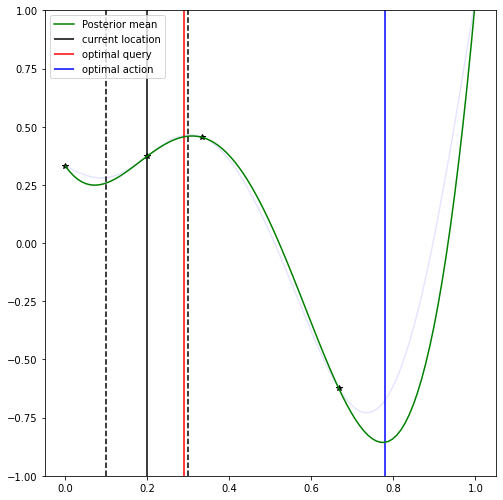

In [ ]:
#@title Joint 5 Steps with sigmoid and adam and sampling

from botorch.sampling.samplers import SobolQMCNormalSampler
from botorch import settings

def compute_ehig(x0, x1, x2, x3, x4, a):
    '''
    x0 to a: unconstraint optimization parameters
    '''
    with settings.propagate_grads(state=True):

        x0 = torch.sigmoid(x0) * 0.2 + (prev_x - 0.1)
        x1 = torch.sigmoid(x1) * 0.2 + (x0 - 0.1)
        x2 = torch.sigmoid(x2) * 0.2 + (x1 - 0.1)
        x3 = torch.sigmoid(x3) * 0.2 + (x2 - 0.1)
        x4 = torch.sigmoid(x4) * 0.2 + (x3 - 0.1)
        a = torch.sigmoid(a) * 0.2 + (x4 - 0.1)

        ehigs = 0
        p_y0_on_x0_D0 = model.posterior(x0)
        sampler = SobolQMCNormalSampler(
            num_samples=4, 
            resample=False, collapse_batch_dims=True
        )
        sample_y0_on_x0_D0 = sampler(p_y0_on_x0_D0)

        for ind_x1 in range(4):
            p_f_on_D1 = model.condition_on_observations(
                x0, sample_y0_on_x0_D0[ind_x1]
            )
            p_y1_on_x1_D1 = p_f_on_D1.posterior(x1[ind_x1, :])
            sample_y1_on_x1_D1 = sampler(p_y1_on_x1_D1)

            for ind_x2 in range(4):
                p_f_on_D2 = p_f_on_D1.condition_on_observations(
                    x1[ind_x1, :], sample_y1_on_x1_D1[ind_x2]
                )
                p_y2_on_x2_D2 = p_f_on_D2.posterior(x2[ind_x1, ind_x2, :])
                sample_y2_on_x2_D2 = sampler(p_y2_on_x2_D2)

                for ind_x3 in range(4):
                    p_f_on_D3 = p_f_on_D2.condition_on_observations(
                        x2[ind_x1, ind_x2, :], sample_y2_on_x2_D2[ind_x3]
                    )
                    p_y3_x3_D3 = p_f_on_D3.posterior(x3[ind_x1, ind_x2, ind_x3, :])
                    sample_y3_on_x3_D3 = sampler(p_y3_x3_D3)

                    for ind_x4 in range(4):
                        p_f_on_D4 = p_f_on_D3.condition_on_observations(
                            x3[ind_x1, ind_x2, ind_x3, :], sample_y3_on_x3_D3[ind_x4]
                        )
                        p_y4_on_x4_D4 = p_f_on_D4.posterior(x4[ind_x1, ind_x2, ind_x3, ind_x4, :])
                        sample_y4_on_x4_D4 = sampler(p_y4_on_x4_D4)

                        for ind_a in range(4):
                            p_f_on_D5 = p_f_on_D4.condition_on_observations(
                                x4[ind_x1, ind_x2, ind_x3, ind_x4, :], sample_y4_on_x4_D4[ind_a]
                            )
                            p_y5_on_a_D5 = p_f_on_D5.posterior(a[ind_x1, ind_x2, ind_x3, ind_x4, ind_a, :])     

                            ehig = p_y5_on_a_D5.mean
                            ehigs = ehigs + ehig
        
        ehig = ehigs / (4**5)
    return x0, a, ehig.squeeze()

prev_x = 0.2
temp = []

x0 = (torch.rand(1)*10).requires_grad_(True)
x1 = (torch.rand(4, 1)*10).requires_grad_(True)
x2 = (torch.rand(4, 4, 1)*10).requires_grad_(True)
x3 = (torch.rand(4, 4, 4, 1)*10).requires_grad_(True)
x4 = (torch.rand(4, 4, 4, 4, 1)*10).requires_grad_(True)
a =  (torch.rand(4, 4, 4, 4, 4, 1)*10).requires_grad_(True)

optimizer = optim.Adam([x0, x1, x2, x3, x4, a], lr=2)
for epoch in tqdm(range(20)):
    optimizer.zero_grad()
    x0_, a_, ehig = compute_ehig(x0, x1, x2, x3, x4, a)
    temp.append([x0_, a_, ehig])
    ehig.backward(retain_graph=True)
    optimizer.step()
    
    if epoch % 2 == 0: 
        print('x0 ', x0.item(), 'a', a[0, 0, 0, 0, 0].item(), 'loss', ehig.item())

# for x0 in tqdm(torch.linspace(-10, 10, 2)):
#     x0 = x0.reshape(1)
#     x0_, a_, ehig = compute_ehig(x0, x1, x2, a)
#     print(ehig)

tmp = []
for i in range(len(temp)):
    tmp.append([temp[i][0], temp[i][1][0, 0, 0, 0, 0], temp[i][2]])
    
tmp = torch.tensor(tmp)
best = torch.argmin(tmp, dim=0)[2].item()
best_x, best_a, best_hes = tmp[best].numpy().tolist()

plt.figure(figsize=(7, 7))
ground_truth(draw=True)

plt.vlines(prev_x, -1, 1, color='black', label='current location')
plt.vlines(prev_x-0.1, -1, 1, color='black', linestyle='--')
plt.vlines(prev_x+0.1, -1, 1, color='black', linestyle='--')

plt.vlines(best_x, -1, 1, color='red', label='optimal query')
plt.vlines(best_a, -1, 1, color='blue', label='optimal action')

plt.plot(
    train_x.cpu().numpy(), 
    train_y.cpu().numpy(), 
    'k*')

# compute posterior
test_x = torch.linspace(0, 1, 100)
posterior = model.posterior(test_x)
test_y = posterior.mean
lower, upper = posterior.mvn.confidence_region()

plt.plot(
    test_x.cpu().detach().numpy(), 
    test_y.cpu().detach().numpy(), 
    'green', label='Posterior mean')

plt.fill_between(
    test_x.cpu().detach().numpy(), 
    lower.cpu().detach().numpy(), 
    upper.cpu().detach().numpy(), 
    alpha=0.25)

plt.tight_layout()
plt.ylim(-1, 1)
plt.legend()

plt.show()

In [ ]:
#@title Joint 5 Steps with sigmoid and adam and sampling -- parallel

from botorch.sampling.samplers import SobolQMCNormalSampler
from botorch import settings
import itertools

def compute_ehig(x0, x1, x2, x3, x4, a):
    '''
    x0 to a: unconstraint optimization parameters
    '''
    with settings.propagate_grads(state=True):

        x0 = torch.sigmoid(x0) * 0.2 + (prev_x - 0.1)
        x1 = torch.sigmoid(x1) * 0.2 + (x0 - 0.1)
        x2 = torch.sigmoid(x2) * 0.2 + (x1 - 0.1)
        x3 = torch.sigmoid(x3) * 0.2 + (x2 - 0.1)
        x4 = torch.sigmoid(x4) * 0.2 + (x3 - 0.1)
        a = torch.sigmoid(a) * 0.2 + (x4 - 0.1)

        ehigs = 0
        p_y0_on_x0_D0 = model.posterior(x0)
        sampler = SobolQMCNormalSampler(
            num_samples=4, 
            resample=False, collapse_batch_dims=True
        )
        sample_y0_on_x0_D0 = sampler(p_y0_on_x0_D0)

        # for ind_x1, y0_on_x0_D0 in enumerate(sample_y0_on_x0_D0):
        sang = 0
        for ind_x1, ind_x2, ind_x3, ind_x4, ind_a in itertools.product(
            range(4), repeat=5
        ):

            sang = sang + 1

            p_f_on_Di = []

            p_f_on_D1 = model.condition_on_observations(
                x0, sample_y0_on_x0_D0[ind_x1]
            )
            p_y1_on_x1_D1 = p_f_on_D1.posterior(x1[ind_x1, :])
            sample_y1_on_x1_D1 = sampler(p_y1_on_x1_D1)



            p_f_on_D2 = p_f_on_D1.condition_on_observations(
                x1[ind_x1, :], sample_y1_on_x1_D1[ind_x2])
            p_y2_on_x2_D2 = p_f_on_D2.posterior(x2[ind_x1, ind_x2, :])
            sample_y2_on_x2_D2 = sampler(p_y2_on_x2_D2)



            p_f_on_D3 = p_f_on_D2.condition_on_observations(
                x2[ind_x1, ind_x2, :], sample_y2_on_x2_D2[ind_x3])
            p_y3_on_x3_D3 = p_f_on_D3.posterior(x3[ind_x1, ind_x2, ind_x3, :])
            sample_y3_on_x3_D3 = sampler(p_y3_on_x3_D3)



            p_f_on_D4 = p_f_on_D3.condition_on_observations(
                x3[ind_x1, ind_x2, ind_x3, :], sample_y3_on_x3_D3[ind_x4])
            p_y4_on_x4_D4 = p_f_on_D4.posterior(x4[ind_x1, ind_x2, ind_x3, ind_x4, :])
            sample_y4_on_x4_D4 = sampler(p_y4_on_x4_D4)



            p_f_on_D5 = p_f_on_D4.condition_on_observations(
                x4[ind_x1, ind_x2, ind_x3, ind_x4, :], sample_y4_on_x4_D4[ind_a])
            p_y5_on_a_D5 = p_f_on_D5.posterior(a[ind_x1, ind_x2, ind_x3, ind_x4, ind_a, :])     

            ehig = p_y5_on_a_D5.mean
            ehigs = ehigs + ehig
        
        ehig = ehigs / (4**5)
        
    print(sang)
    return x0, a, ehig.squeeze()

prev_x = 0.2
temp = []

x0 = (torch.rand(1)*10).requires_grad_(True)
x1 = (torch.rand(4, 1)*10).requires_grad_(True)
x2 = (torch.rand(4, 4, 1)*10).requires_grad_(True)
x3 = (torch.rand(4, 4, 4, 1)*10).requires_grad_(True)
x4 = (torch.rand(4, 4, 4, 4, 1)*10).requires_grad_(True)
a =  (torch.rand(4, 4, 4, 4, 4, 1)*10).requires_grad_(True)

optimizer = optim.Adam([x0, x1, x2, x3, x4, a], lr=2)
for epoch in tqdm(range(20)):
    optimizer.zero_grad()
    x0_, a_, ehig = compute_ehig(x0, x1, x2, x3, x4, a)
    temp.append([x0_, a_, ehig])
    ehig.backward(retain_graph=True)
    optimizer.step()
    
    if epoch % 2 == 0: 
        print('x0 ', x0.item(), 'a', a[0, 0, 0, 0, 0].item(), 'loss', ehig.item())

# for x0 in tqdm(torch.linspace(-10, 10, 2)):
#     x0 = x0.reshape(1)
#     x0_, a_, ehig = compute_ehig(x0, x1, x2, a)
#     print(ehig)

tmp = []
for i in range(len(temp)):
    tmp.append([temp[i][0], temp[i][1][0, 0, 0, 0, 0], temp[i][2]])
    
tmp = torch.tensor(tmp)
best = torch.argmin(tmp, dim=0)[2].item()
best_x, best_a, best_hes = tmp[best].numpy().tolist()

plt.figure(figsize=(7, 7))
ground_truth(draw=True)

plt.vlines(prev_x, -1, 1, color='black', label='current location')
plt.vlines(prev_x-0.1, -1, 1, color='black', linestyle='--')
plt.vlines(prev_x+0.1, -1, 1, color='black', linestyle='--')

plt.vlines(best_x, -1, 1, color='red', label='optimal query')
plt.vlines(best_a, -1, 1, color='blue', label='optimal action')

plt.plot(
    train_x.cpu().numpy(), 
    train_y.cpu().numpy(), 
    'k*')

# compute posterior
test_x = torch.linspace(0, 1, 100)
posterior = model.posterior(test_x)
test_y = posterior.mean
lower, upper = posterior.mvn.confidence_region()

plt.plot(
    test_x.cpu().detach().numpy(), 
    test_y.cpu().detach().numpy(), 
    'green', label='Posterior mean')

plt.fill_between(
    test_x.cpu().detach().numpy(), 
    lower.cpu().detach().numpy(), 
    upper.cpu().detach().numpy(), 
    alpha=0.25)

plt.tight_layout()
plt.ylim(-1, 1)
plt.legend()

plt.show()

In [ ]:
import itertools

g = itertools.product(enumerate(range(1,10)), enumerate(range(1,10)), enumerate(range(1,10)))

%timeit [print(i) for i in g]


# def seperate():
#     for i in range(1,10):
#         for j in range(1,10):
#             for k in range(1,10):
#                 print (i,j,k)

# %timeit seperate()


((0, 1), (0, 1), (0, 1))
((0, 1), (0, 1), (1, 2))
((0, 1), (0, 1), (2, 3))
((0, 1), (0, 1), (3, 4))
((0, 1), (0, 1), (4, 5))
((0, 1), (0, 1), (5, 6))
((0, 1), (0, 1), (6, 7))
((0, 1), (0, 1), (7, 8))
((0, 1), (0, 1), (8, 9))
((0, 1), (1, 2), (0, 1))
((0, 1), (1, 2), (1, 2))
((0, 1), (1, 2), (2, 3))
((0, 1), (1, 2), (3, 4))
((0, 1), (1, 2), (4, 5))
((0, 1), (1, 2), (5, 6))
((0, 1), (1, 2), (6, 7))
((0, 1), (1, 2), (7, 8))
((0, 1), (1, 2), (8, 9))
((0, 1), (2, 3), (0, 1))
((0, 1), (2, 3), (1, 2))
((0, 1), (2, 3), (2, 3))
((0, 1), (2, 3), (3, 4))
((0, 1), (2, 3), (4, 5))
((0, 1), (2, 3), (5, 6))
((0, 1), (2, 3), (6, 7))
((0, 1), (2, 3), (7, 8))
((0, 1), (2, 3), (8, 9))
((0, 1), (3, 4), (0, 1))
((0, 1), (3, 4), (1, 2))
((0, 1), (3, 4), (2, 3))
((0, 1), (3, 4), (3, 4))
((0, 1), (3, 4), (4, 5))
((0, 1), (3, 4), (5, 6))
((0, 1), (3, 4), (6, 7))
((0, 1), (3, 4), (7, 8))
((0, 1), (3, 4), (8, 9))
((0, 1), (4, 5), (0, 1))
((0, 1), (4, 5), (1, 2))
((0, 1), (4, 5), (2, 3))
((0, 1), (4, 5), (3, 4))


In [ ]:
# gold standard -- exhastive search over x and a

# set noise level to almost 0

# first query at a

# for x in (a-0.1, a+0.1):

    # compute y | x, D 

    # for y in sample y (only need 1 sample if the noise is small) 

        # for a in (x-0.1, x+0.1):

            # compute  y' | x, y, a

            # compute the mean


In [ ]:
i = 4
i + i**2 + i**3 + i**4 + i**5 + i**6 + i**7 + i**8 + i**9 + i**10

1398100